# How can we sample

In [1]:
import nbloader
import tensorflow as tf
import numpy as np
from demo_util import animate_frames,gpusession
print ("Packages loaded")
print 'TF version: '+tf.__version__

Importing Jupyter notebook from [demo_util.ipynb]
Packages loaded
TF version: 1.3.0


Make a class for Bayes by backprob (BBB)

In [2]:
def multiply_tuple(vals):
    mval = 1
    for vIdx in range(len(vals)):
        mval = mval*vals[vIdx]
    return mval

class bbb(object):
    def __init__(self,_name='P',_distribution='Gaussian',_shape=(10,10),
                 _trainable=True,_VERBOSE=True):
        # Parse inputs
        self.name = _name
        self.distribution = _distribution
        self.shape = _shape
        self.trainable = _trainable
        self.VERBOSE = _VERBOSE
        # Place holder 
        self.dim = multiply_tuple(self.shape)
        self.x = tf.placeholder(dtype=tf.float32,shape=[None,self.dim])
        # Initialize distribution
        self.init_distribution()
        self.init_logProb()
        # Initialize sampler
        self.init_sampler()
        # Print
        if self.VERBOSE:
            print ("bbb[%s] instantiated."%(self.name))
        # Check variables
        if self.VERBOSE:
            print ("Global variables")
        _g_vars = tf.global_variables()
        self.g_vars = [var for var in _g_vars if '%s/'%(self.name) in var.name]
        for i in range(len(self.g_vars)):
            w_name  = self.g_vars[i].name
            w_shape = self.g_vars[i].get_shape().as_list()
            if self.VERBOSE:
                print (" [%d] Name:[%s] Shape:[%s]" % (i,w_name,w_shape))
        
    def init_distribution(self):
        with tf.variable_scope(self.name,reuse=False) as scope:
            if self.trainable: # Variational distribution approximating posterior
                if self.distribution is 'Gaussian':
                    self.mu = tf.get_variable(name=self.name+'_mu',
                                              shape=[1,self.dim],
                                              dtype=tf.float32)
                    self.logSigma = tf.get_variable(name=self.name+'_logSigma',
                                              shape=[1,self.dim],
                                              dtype=tf.float32)
                else:
                    print ("What is [%s]?"%(self.distribution))
            else: # Prior distribution
                if self.distribution is 'Gaussian':
                    self.mu = tf.constant(np.zeros((1,self.dim)),
                                          name=self.name+'_mu',
                                          dtype=tf.float32)
                    self.logSigma = tf.constant(np.zeros((1,self.dim)),
                                                name=self.name+'_logSigma',
                                                dtype=tf.float32)
                else:
                    print ("What is [%s]?"%(self.distribution))
                
    def variable_initializer(self,_sess):
        if self.trainable: # Variational distribution 
            # We assume global_variables_initializer is called
            if self.distribution is 'Gaussian':
                _sess.run(tf.assign(self.mu,np.zeros((1,self.dim))))
                _sess.run(tf.assign(self.logSigma,np.zeros((1,self.dim))))
            else:
                print ("What is [%s]?"%(self.distribution))
                
    def init_logProb(self):
        if self.distribution is 'Gaussian':
            # _x is assumed to be a matrix of (N x d)
            self.nX = tf.shape(self.x)[0]
            self.dimX = tf.shape(self.x)[1]
            self.muTile = tf.tile(tf.reshape(self.mu,[1,-1]),[self.nX,1])
            self.sigmaTile = tf.exp(tf.tile(
                tf.reshape(self.logSigma,[1,-1]),[self.nX,1]))
            self.const = -0.5*np.log(np.pi)* \
                tf.ones_like(tensor=self.muTile,dtype=tf.float32)
            self.logsig = -0.5*tf.log(self.sigmaTile)
            self.quad = -0.5*(self.x-self.muTile)**2/self.sigmaTile
            self.logProbs = self.const+self.logsig+self.quad
            self.logProbs = tf.reduce_sum(self.logProbs,axis=1)
        else:
            print ("What is [%s]?"%(self.distribution))
    
    def init_sampler(self):
        self.nSample = tf.placeholder(dtype=tf.int32,name='nSample')
        if self.distribution is 'Gaussian':
            eps = tf.random_normal(shape=[self.nSample,self.dim],
                                   mean=0,stddev=1,dtype=tf.float32)
            self.sampler = tf.tile(self.mu,[self.nSample,1]) + \
                tf.tile(tf.sqrt(tf.exp(self.logSigma)),
                        [self.nSample,1])*eps
        else:
            print ("What is [%s]?"%(self.distribution))


## Show basic usage of BBB


===Initialize distributions===
bbb[P] instantiated.
Global variables
bbb[Q] instantiated.
Global variables
 [0] Name:[Q/Q_mu:0] Shape:[[1, 100]]
 [1] Name:[Q/Q_logSigma:0] Shape:[[1, 100]]

===Draw samples from the distribution===
nSample:[10]
Shape of 'Psamples':(10, 100)
Shape of 'Psamples':(10, 100)

===Compute log probabilities of the samples===
Shape of 'P-logProbs':(10,)
Shape of 'Q-logProbs':(10,)
Log probabilities:
 P: [-106.054855 -103.127815 -103.8624   -127.68601  -124.414024  -96.37378
 -114.18376  -105.67824  -100.03691  -101.54893 ]
 Q: [ -94.06979   -93.96938  -106.50828  -109.274666 -102.38854   -98.6804
 -107.441734  -94.17444  -102.76566  -111.52919 ]



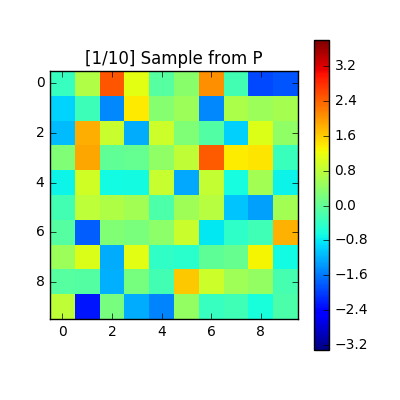
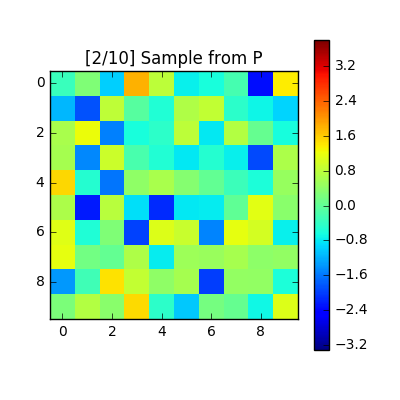
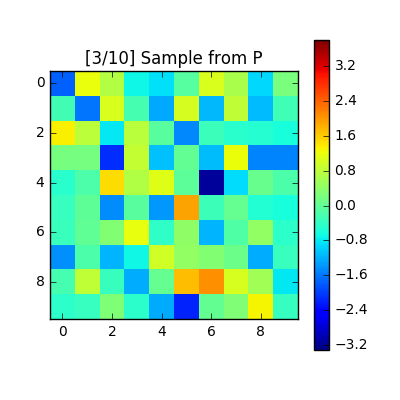
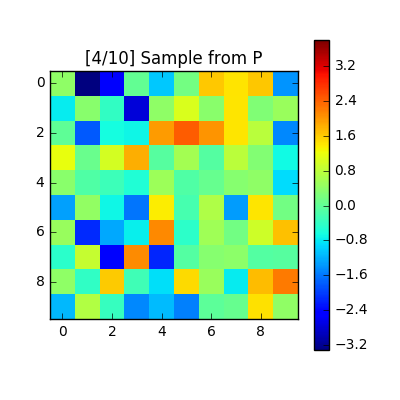
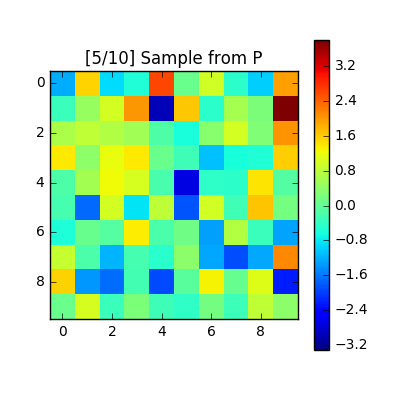
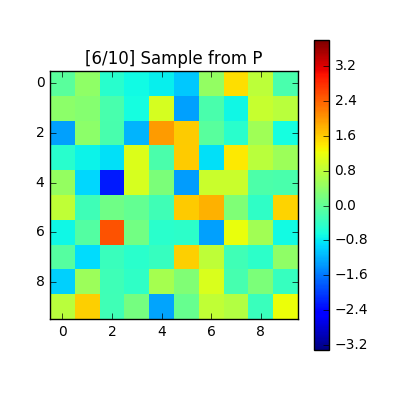
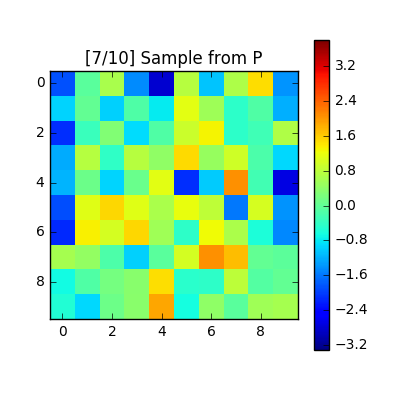
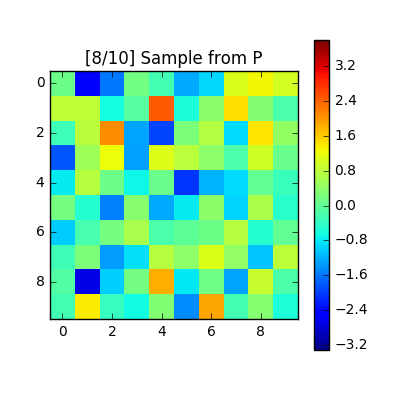
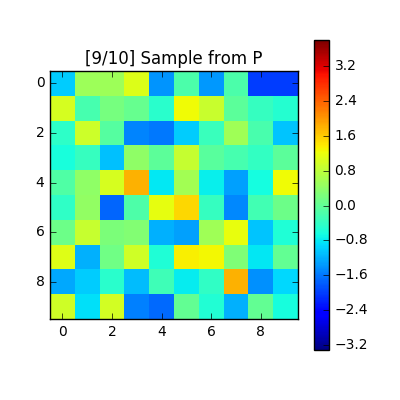
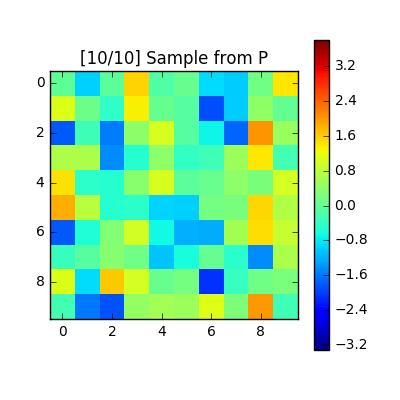


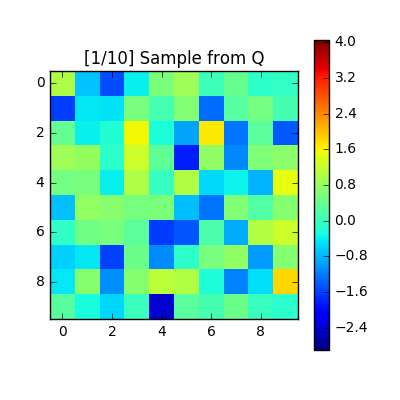
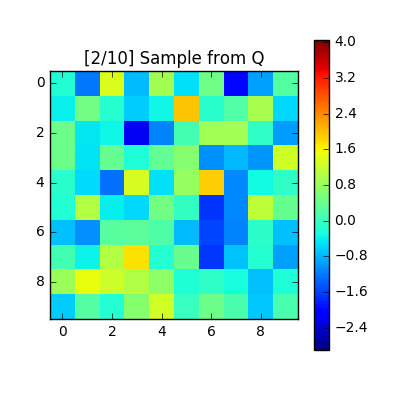
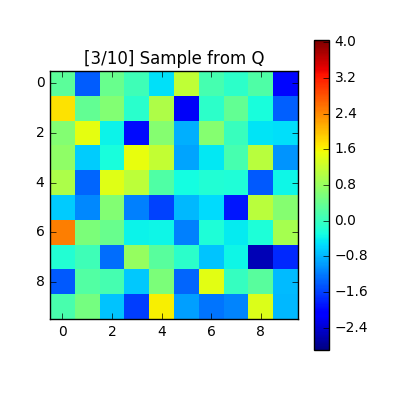
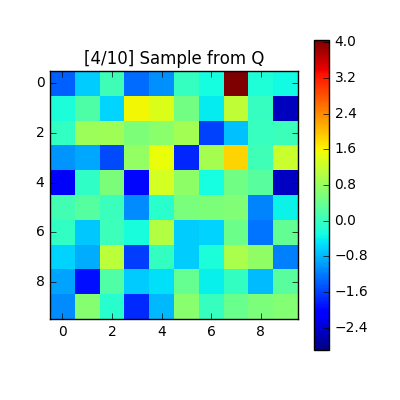
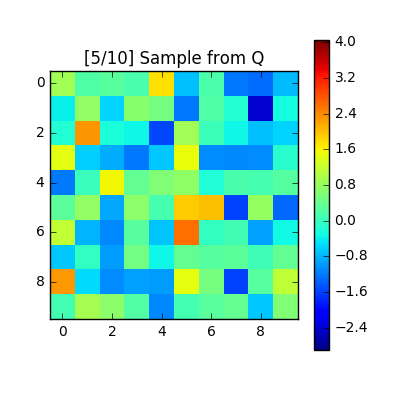
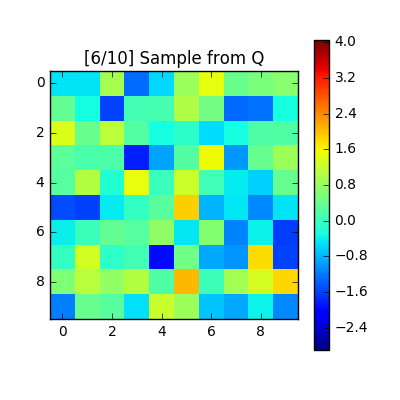
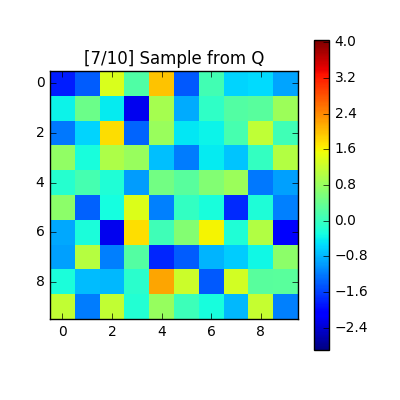
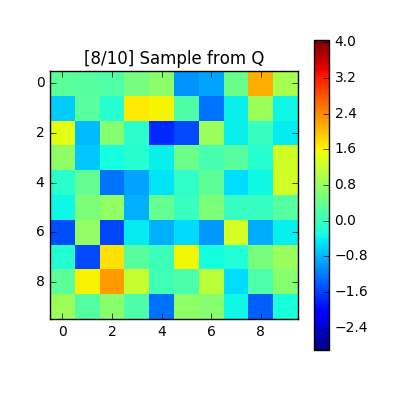
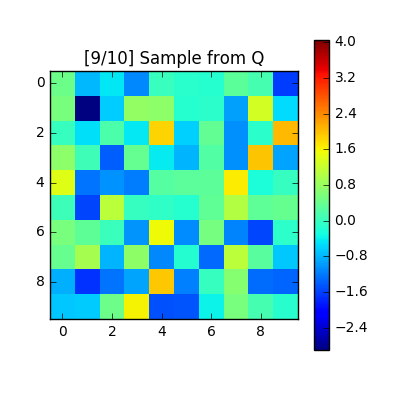
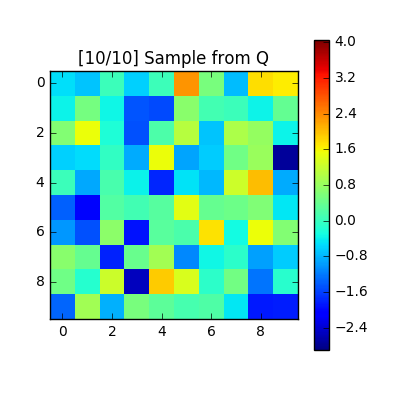

In [3]:
if __name__ == "__main__":
    # Open session
    sess = gpusession() 
    # Initialize distributions
    print ("\n===Initialize distributions===")
    P = bbb(_name='P',_distribution='Gaussian',_shape=[10,10],
            _trainable=False)
    Q = bbb(_name='Q',_distribution='Gaussian',_shape=[10,10],
            _trainable=True)
    sess.run(tf.global_variables_initializer())
    P.variable_initializer(_sess=sess)
    Q.variable_initializer(_sess=sess)
    # Draw samples from the distribution
    print ("\n===Draw samples from the distribution===")
    nSample = 10
    print ("nSample:[%d]"%(nSample))
    Psamples = sess.run(P.sampler,feed_dict={P.nSample:nSample}) 
    Qsamples = sess.run(Q.sampler,feed_dict={Q.nSample:nSample}) 
    print "Shape of 'Psamples':%s"%(Psamples.shape,)
    print "Shape of 'Psamples':%s"%(Qsamples.shape,)
    # Compute log probabilities of the samples
    print ("\n===Compute log probabilities of the samples===")
    PlogProbs = sess.run(P.logProbs,feed_dict={P.x:Psamples})
    QlogProbs = sess.run(Q.logProbs,feed_dict={Q.x:Qsamples})
    print "Shape of 'P-logProbs':%s"%(PlogProbs.shape,)
    print "Shape of 'Q-logProbs':%s"%(QlogProbs.shape,)
    print "Log probabilities:"
    print ' P:',PlogProbs
    print ' Q:',QlogProbs
    # Animate P
    animate_frames(_frames=np.reshape(Psamples,[-1]+P.shape),_figsize=(4,4),
                   _title='Sample from P')
    # Animate Q
    animate_frames(_frames=np.reshape(Qsamples,[-1]+Q.shape),_figsize=(4,4),
                   _title='Sample from Q')